In [11]:
from __future__ import annotations
import random, math, torch, matplotlib as mpl, numpy as np, matplotlib.pyplot as plt
import fastcore.all as fc
from fastcore.test import test_close 
from pathlib import Path
from operator import attrgetter, itemgetter
from functools import partial
import logging, sys, os

from torch import tensor, nn, optim
import torch.nn.functional as F 
import torchvision.transforms.functional as TF 
from datasets import load_dataset 

sys.path.append(os.path.abspath('..'))

from data_utils import *
from learners import *
from callbacks import *
from metrics import *
from utils import *


In [12]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['figure.constrained_layout.use'] = True

logging.disable(logging.WARNING)

In [13]:
# export
def set_seed(seed):
    torch.use_deterministic_algorithms(True)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [14]:
x, y = 'image', 'label'
name = 'fashion_mnist'
dsd = load_dataset(name)
bs = 1024

@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

# Baseline

In [15]:
def conv(input_channels, output_channels, kernel_size=3, act=True):
    res = nn.Conv2d(in_channels=input_channels,
                    out_channels=output_channels,    
                    kernel_size=kernel_size,
                    padding=kernel_size//2
    )
    if act: res = nn.Sequential(res, nn.ReLU())
    return res 

def cnn_layers():
    return [
        conv(1,8,5),
        conv(8,16),
        conv(16,32),
        conv(32,64),
        conv(64,10, act=False),
        nn.Flatten()
    ]

In [16]:
from torcheval.metrics import MulticlassAccuracy

In [17]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]

In [53]:
def fit(model, epochs=1, xtra_cbs=None):
    learn = Learner(model, dls, loss_func=F.cross_entropy, lr=0.6, cbs=cbs+fc.L(xtra_cbs))
    learn.fit(epochs)
    return learn

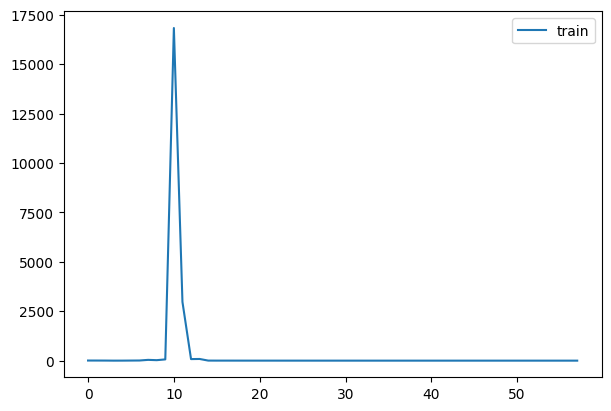

In [11]:
set_seed(1)
learn = fit(nn.Sequential(*cnn_layers()))

# hooks

## model insertion

In [19]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds = [[] for _ in layers]

    def __call__(self, x):
        for i, l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(to_cpu(x).mean())
            self.act_stds[i].append(to_cpu(x).std())
        return x

    def __iter__(self): return iter(self.layers)

err before_fit <callbacks.train_callback.TrainCB object at 0x75d286a116a0>
ok
ok
ok


err before_epoch <callbacks.train_callback.TrainCB object at 0x75d286a116a0>
err before_epoch <callbacks.device_callback.DeviceCB object at 0x75d2869ffa10>
ok
ok
err before_batch <callbacks.train_callback.TrainCB object at 0x75d286a116a0>
ok
err before_batch <callbacks.metrics_callback.MetricsCB object at 0x75d2869ffef0>
err before_batch <callbacks.progress_callback.ProgressCB object at 0x75d28694c470>
tensor([[-0.03, -0.04, -0.04,  ..., -0.02, -0.02, -0.03],
        [-0.03, -0.04, -0.03,  ..., -0.02, -0.03, -0.03],
        [-0.03, -0.04, -0.04,  ..., -0.02, -0.03, -0.03],
        ...,
        [-0.03, -0.04, -0.04,  ..., -0.02, -0.03, -0.03],
        [-0.03, -0.04, -0.04,  ..., -0.02, -0.03, -0.03],
        [-0.03, -0.04, -0.04,  ..., -0.02, -0.03, -0.03]], grad_fn=<ViewBackward0>)
ok
err predict <callbacks.device_callback.DeviceCB object at 0x75d2869ffa10>
err predict <callbacks.metrics_callback.MetricsCB object at 0x75d2869ffef0>
err predict <callbacks.progress_callback.ProgressCB ob

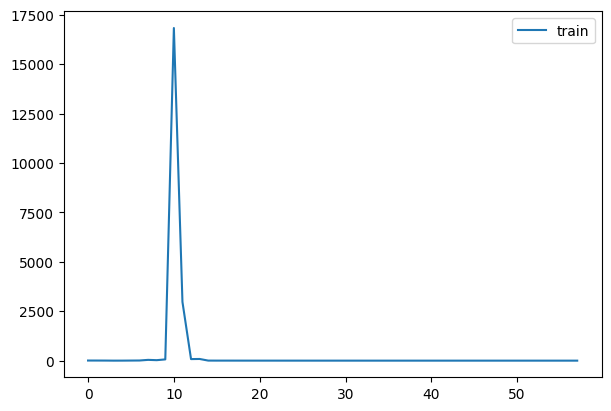

ok
err before_batch <callbacks.train_callback.TrainCB object at 0x75d286a116a0>
ok
err before_batch <callbacks.metrics_callback.MetricsCB object at 0x75d2869ffef0>
err before_batch <callbacks.progress_callback.ProgressCB object at 0x75d28694c470>
tensor([[ 0.67,  0.72,  0.72,  ..., -0.09, -0.09, -0.09],
        [ 0.67,  0.72,  0.72,  ..., -0.09, -0.09, -0.09],
        [ 0.67,  0.72,  0.72,  ..., -0.09, -0.09, -0.09],
        ...,
        [ 0.67,  0.72,  0.72,  ..., -0.09, -0.09, -0.09],
        [ 0.67,  0.72,  0.72,  ..., -0.09, -0.09, -0.09],
        [ 0.67,  0.72,  0.72,  ..., -0.09, -0.09, -0.09]], grad_fn=<ViewBackward0>)
ok
err predict <callbacks.device_callback.DeviceCB object at 0x75d2869ffa10>
err predict <callbacks.metrics_callback.MetricsCB object at 0x75d2869ffef0>
err predict <callbacks.progress_callback.ProgressCB object at 0x75d28694c470>
ok
err get_loss <callbacks.device_callback.DeviceCB object at 0x75d2869ffa10>
err get_loss <callbacks.metrics_callback.MetricsCB object

In [15]:
set_seed(1)
model = SequentialModel(*cnn_layers())
learn = fit(model)

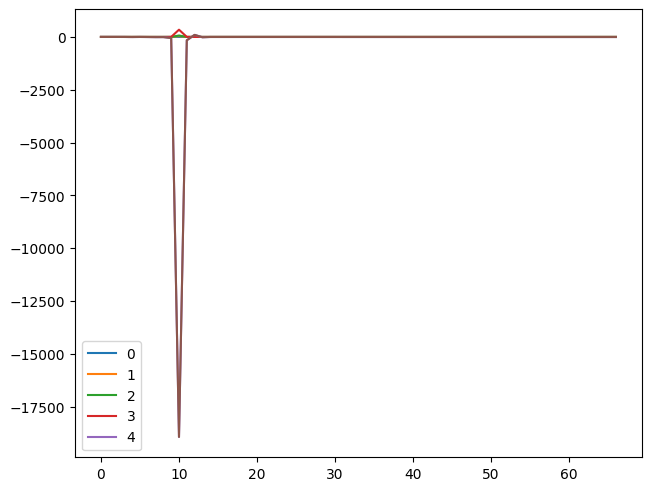

In [19]:
for l in model.act_means: plt.plot(l)
plt.legend(range(5))

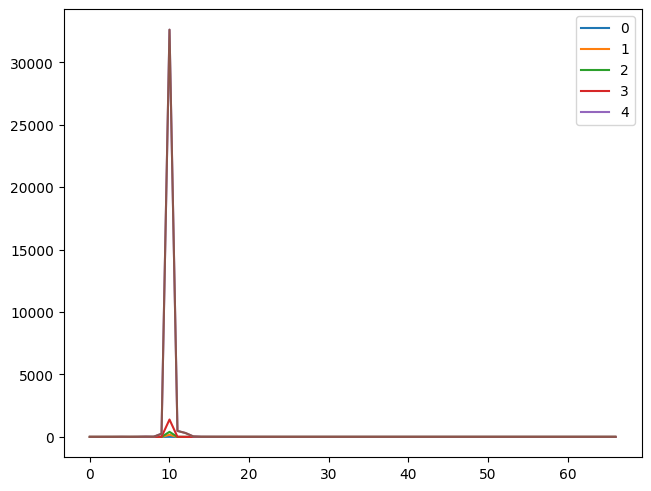

In [20]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(5))

## pytorch hooks

In [20]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

act_means = [[] for _ in model]
act_stds = [[] for _ in model]

def append_stats(i, mod, inp, outp):
    act_means[i].append(to_cpu(outp).mean())
    act_stds [i].append(to_cpu(outp).std())

In [21]:
for i,m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

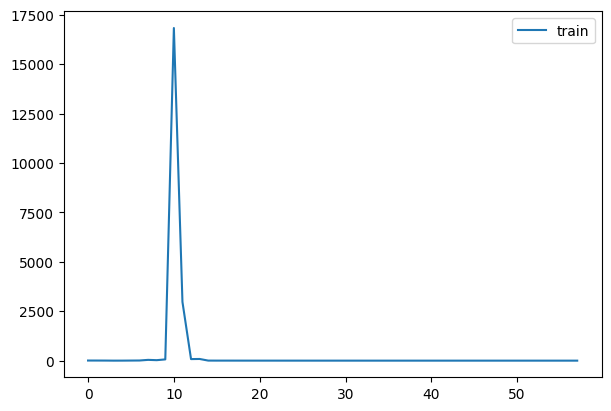

In [12]:
fit(model)

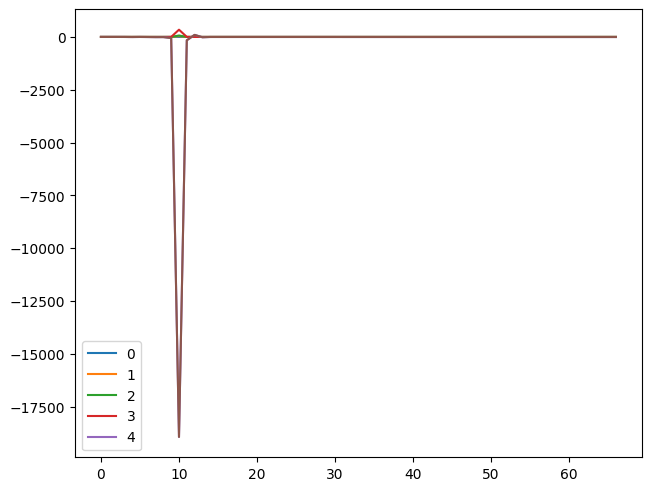

In [13]:
for o in act_means: plt.plot(o)
plt.legend(range(5))

## hook class

In [22]:
# need to export
class Hook():
    def __init__(self, model, function): self.hook = model.register_forward_hook(partial(function, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

def append_stats(hook, model, input, output):
    if not hasattr(hook, 'stats'): hook.stats = ([],[])
    acts = to_cpu(output)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())

In [23]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

In [24]:
hooks = [Hook(l, append_stats) for l in model[:5].children()]

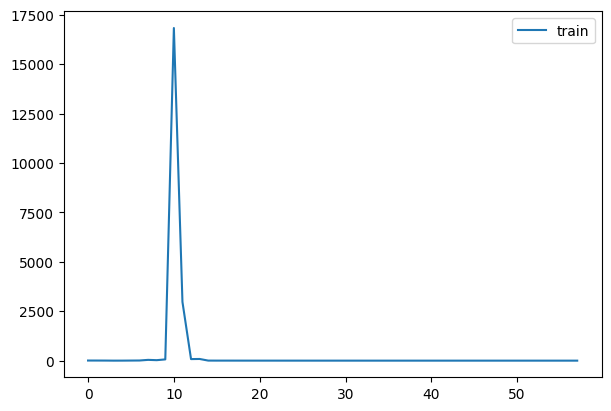

In [28]:
learn = fit(model)

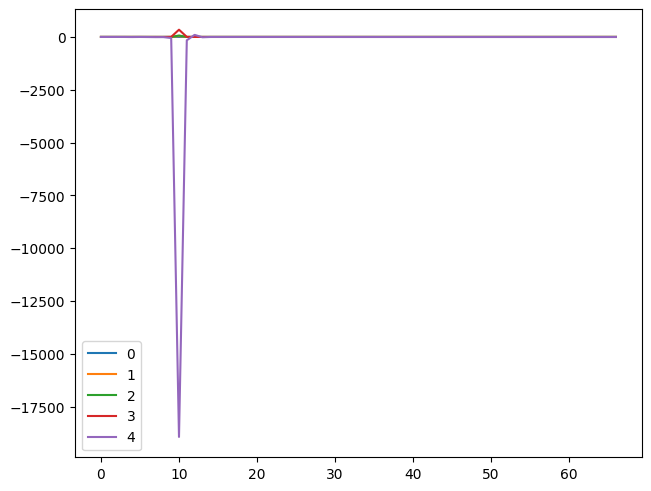

In [29]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(5))

## hooks class

In [25]:
class DummyCtsMgr:
    def __enter__(self, *args):
        print("let's go")
        return self
    def __exit__(self, *args): print("all done!")
    def hello(self): print('hello')

In [26]:
with DummyCtsMgr() as dcm: dcm.hello()

let's go
hello
all done!


In [27]:
class DummyList(list):
    def __delitem__(self, i):
        print(f"bye {i}")
        super().__delitem__(i)

In [28]:
dml = DummyList([1,2,3])
dml

[1, 2, 3]

In [29]:
del(dml[2])
dml

bye 2


[1, 2]

In [30]:
# export
class Hooks(list):
    def __init__(self, methods, func): super().__init__([Hook(m, func) for m in methods])
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.remove()
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
    def remove(self):
        for h in self: h.remove()

In [31]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

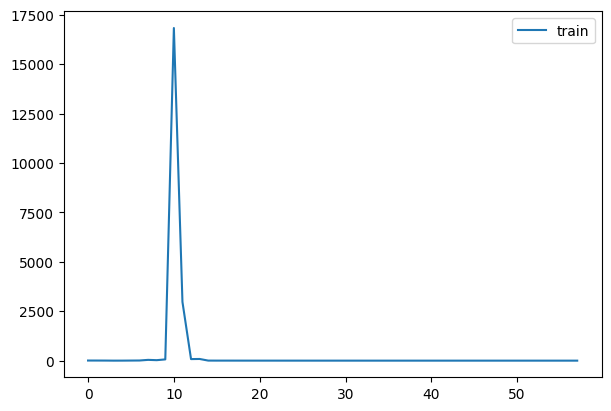

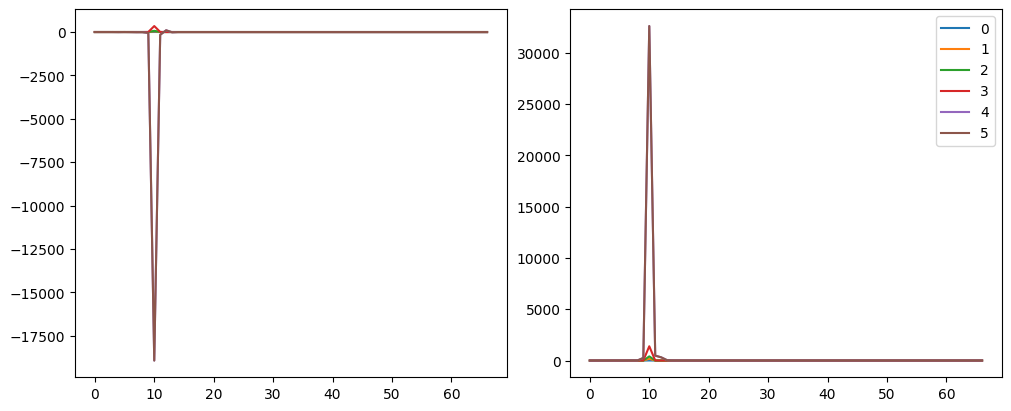

In [41]:
with Hooks(model, append_stats) as hooks:
    fit(model)
    fig, axs = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        for i in 0, 1: axs[i].plot(h.stats[i])
    plt.legend(range(6))

In [32]:
# export
def append_stats(hook, model, input, output):
    if not hasattr(hook, 'stats'): hook.stats = ([],[],[])
    acts = to_cpu(output)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())
    hook.stats[2].append(acts.abs().histc(40,0,10))

In [33]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

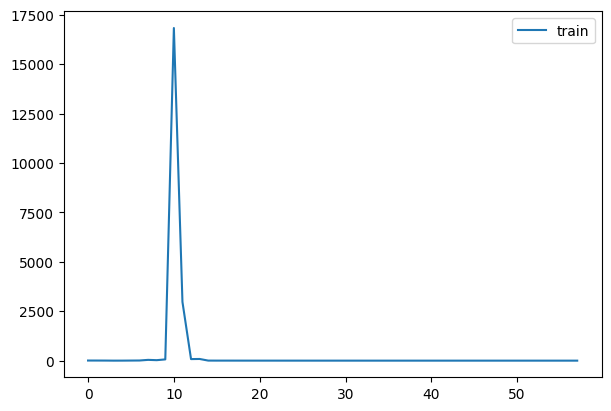

In [24]:
3 with Hooks(model, append_stats) as hooks: fit(model)

In [34]:
# export

def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

In [35]:
# export
@fc.delegates(plt.Axes.imshow)
def show_image(im, ax=None, figsize=None, title=None, noframe=True, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    if fc.hasattrs(im, ('cpu','permute','detach')):
        im = im.detach().cpu()
        if len(im.shape)==3 and im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=np.array(im)
    if im.shape[-1]==1: im=im[...,0]
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    if noframe: ax.axis('off')
    return ax

In [36]:
#export

@fc.delegates(plt.subplots, keep=True)
def subplots(
    nrows:int=1, # Number of rows in returned axes grid
    ncols:int=1, # Number of columns in returned axes grid
    figsize:tuple=None, # Width, height in inches of the returned figure
    imsize:int=3, # Size (in inches) of images that will be displayed in the returned figure
    suptitle:str=None, # Title to be set to returned figure
    **kwargs
): # fig and axs
    "A figure and set of subplots to display images of `imsize` inches"
    if figsize is None: figsize=(ncols*imsize, nrows*imsize)
    fig,ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    if suptitle is not None: fig.suptitle(suptitle)
    if nrows*ncols==1: ax = np.array([ax])
    return fig,ax

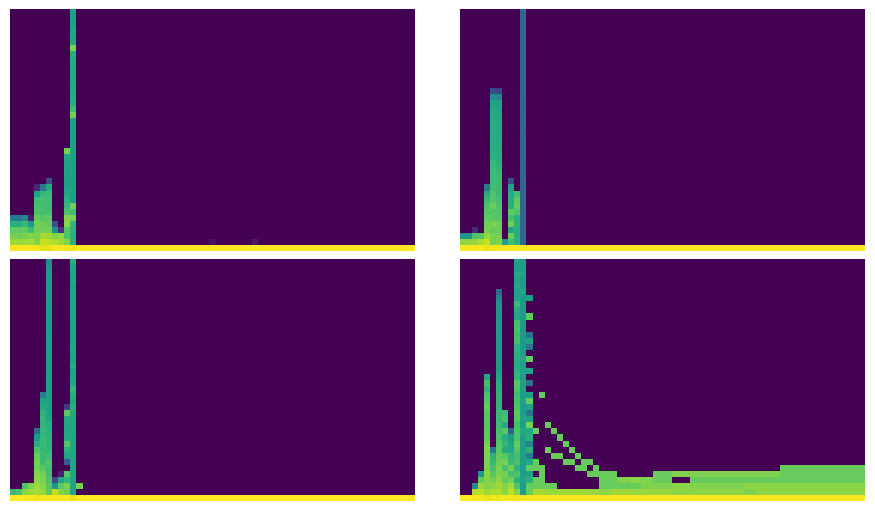

In [33]:
fig, axes = subplots(2,2, figsize=(9,5))
for ax, h in zip(axes.flatten(), hooks[:4]):
    show_image(get_hist(h), ax, origin='lower')

In [37]:
# export
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[:2].sum(0) / h1.sum(0)

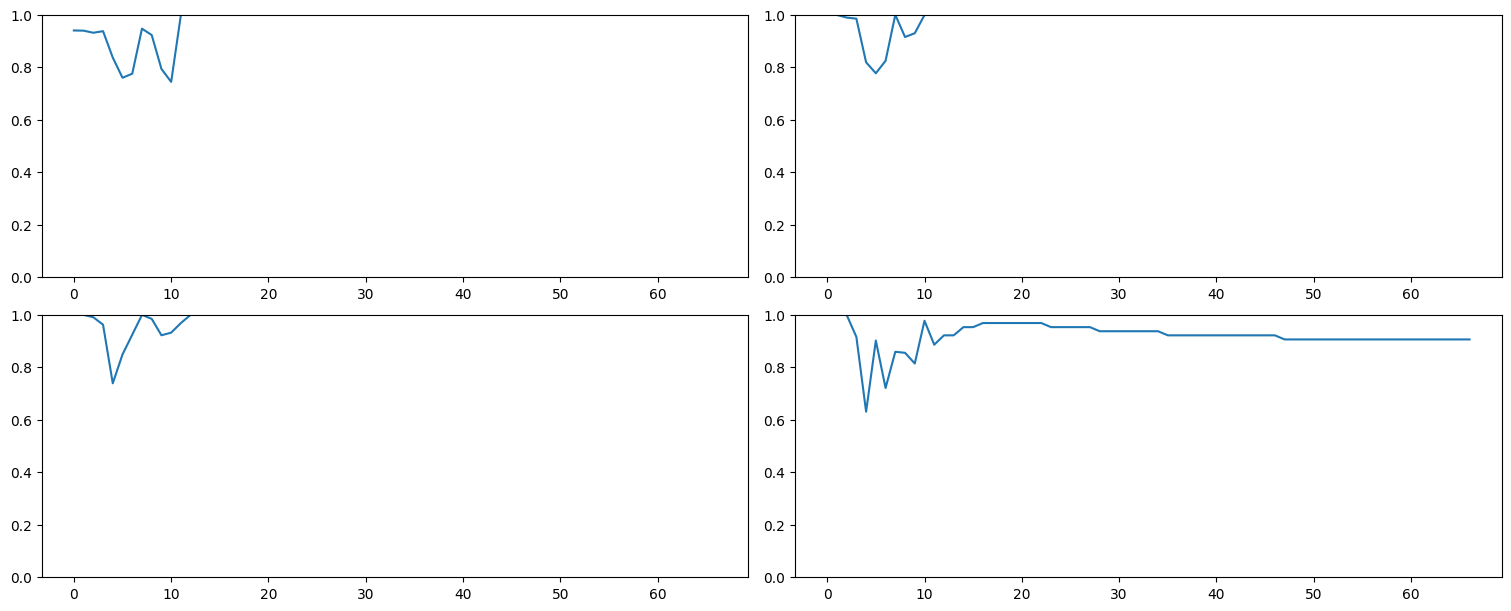

In [35]:
fig, axes = subplots(2,2, figsize=(15,6))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)

## HooksCallback

In [55]:
class HooksCallback(Callback):
    def __init__(self, hookfunc, mod_filter=fc.noop):
        fc.store_attr()
        super().__init__()
    def before_fit(self):
        mods = fc.filter_ex(self.learn.model.modules(), self.mod_filter)
        self.hooks = Hooks(mods, self._hookfunc)
    def _hookfunc(self, *args, **kwargs):
        if self.learn.model.training: self.hookfunc(*args, **kwargs)
    
    def after_fit(self): self.hooks.remove()
    def __iter__(self): return iter(self.hooks)
    def __len__(self): return len(self.hooks)

In [56]:
hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.Conv2d))

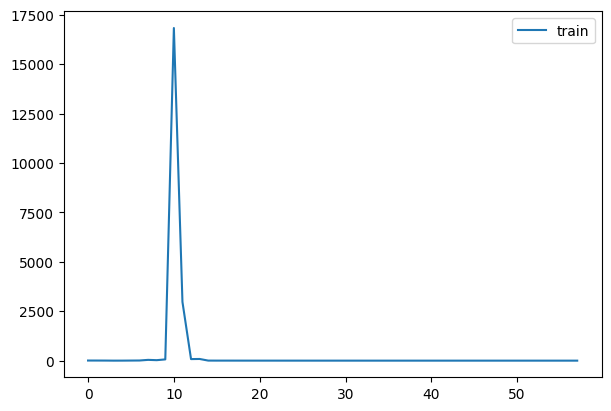

In [57]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
fit(model, xtra_cbs=[hc])

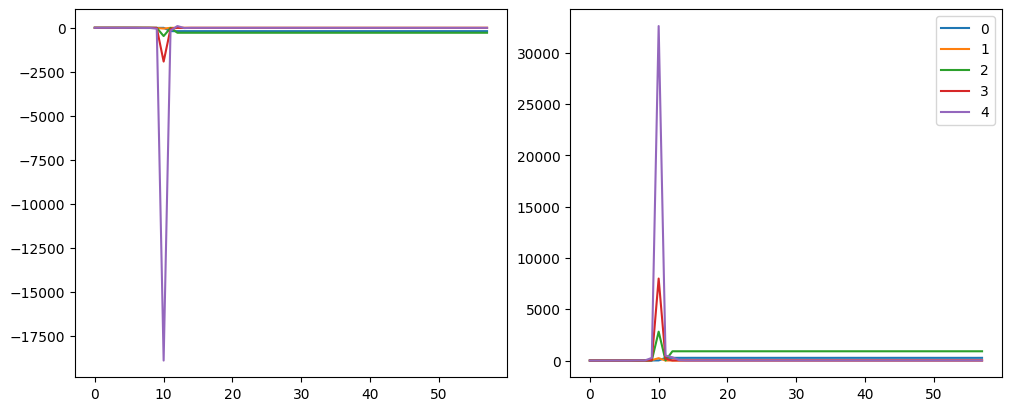

In [59]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
for h in hc:
    for i in 0,1: axs[i].plot(h.stats[i])
plt.legend(range(6))

In [60]:
# export
@fc.delegates(subplots)
def get_grid(
    n:int, # Number of axes
    nrows:int=None, # Number of rows, defaulting to `int(math.sqrt(n))`
    ncols:int=None, # Number of columns, defaulting to `ceil(n/rows)`
    title:str=None, # If passed, title set to the figure
    weight:str='bold', # Title font weight
    size:int=14, # Title font size
    **kwargs,
): # fig and axs
    "Return a grid of `n` axes, `rows` by `cols`"
    if nrows: ncols = ncols or int(np.floor(n/nrows))
    elif ncols: nrows = nrows or int(np.ceil(n/ncols))
    else:
        nrows = int(math.sqrt(n))
        ncols = int(np.floor(n/nrows))
    fig,axs = subplots(nrows, ncols, **kwargs)
    for i in range(n, nrows*ncols): axs.flat[i].set_axis_off()
    if title is not None: fig.suptitle(title, weight=weight, size=size)
    return fig,axs

In [61]:
# export
@fc.delegates(subplots)
def show_images(ims:list, # Images to show
                nrows:int|None=None, # Number of rows in grid
                ncols:int|None=None, # Number of columns in grid (auto-calculated if None)
                titles:list|None=None, # Optional list of titles for each image
                **kwargs):
    "Show all images `ims` as subplots with `rows` using `titles`"
    axs = get_grid(len(ims), nrows, ncols, **kwargs)[1].flat
    for im,t,ax in zip_longest(ims, titles or [], axs): show_image(im, ax=ax, title=t)


In [66]:
class ActivationStats(HooksCallback):
    def __init__(self, mod_filter=fc.noop): super().__init__(append_stats, mod_filter)

    def color_dim(self, figsize=(11,5)):
        fig, axes = get_grid(len(self), figsize=figsize)
        for ax, h in zip(axes.flat, self):
            show_image(get_hist(h), ax, origin='lower')
    def dead_chart(self, figsize=(11,5)):
        fig, axes = get_grid(len(self), figsize=figsize)
        for ax, h in zip(axes.flatten(), self):
            ax.plot(get_min(h))
            ax.set_ylim(0,1)

    def plot_stats(self, figsize=(10,4)):
        fig, axs = plt.subplots(1,2, figsize=figsize)
        for h in self:
            for  i in 0, 1: axs[i].plot(h.stats[i])
        axs[0].set_title('Means')
        axs[1].set_title("Stdevs")
        plt.legend(fc.L.range(self))

In [67]:
astats = ActivationStats(fc.risinstance(nn.Conv2d))

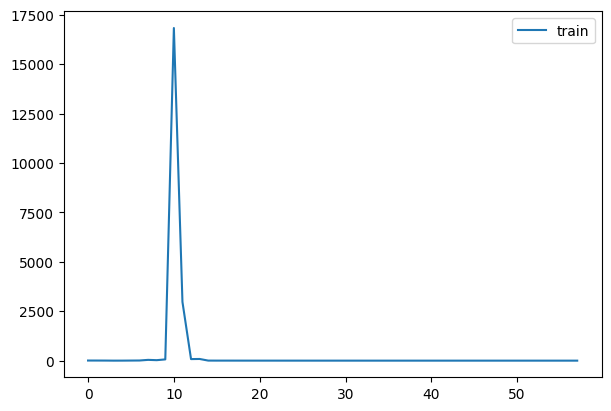

In [69]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
fit(model, xtra_cbs=[astats])

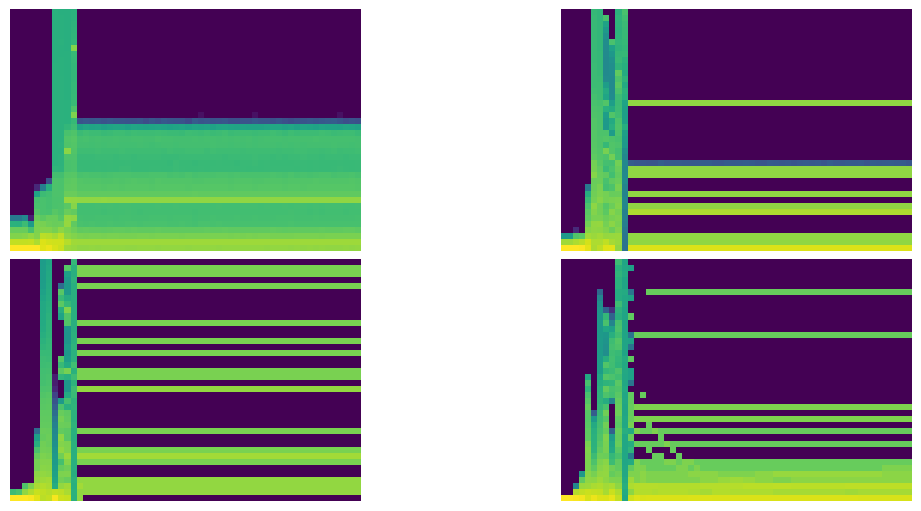

In [70]:
astats.color_dim()

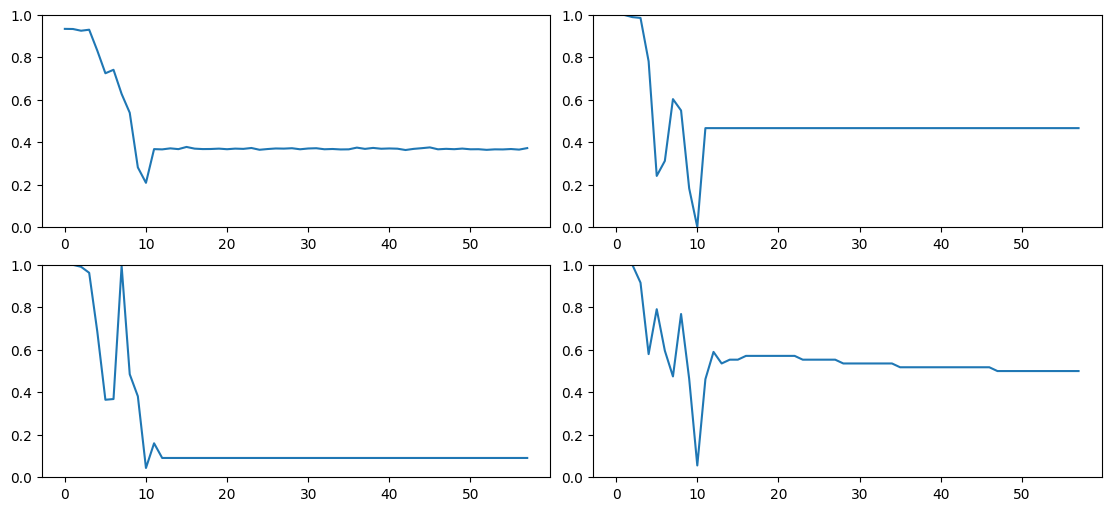

In [71]:
astats.dead_chart()

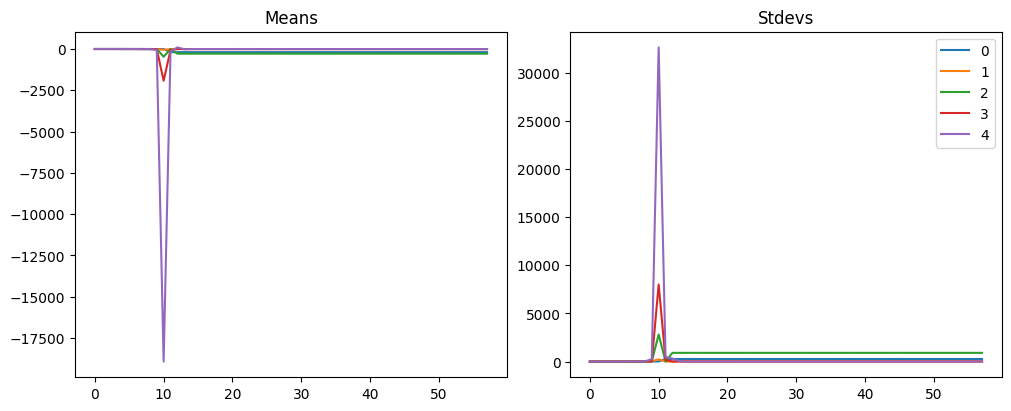

In [72]:
astats.plot_stats()